## Load the dataset

In [26]:
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


# load the UCL Real Estate Valuation dataset
ucl_data_path = '../Data/UCI_Real_Estate_Valuation.xlsx'
ucl_data = pd.read_excel(ucl_data_path)

# Drop the 'No' column as it's just an identifier
ucl_data = ucl_data.drop('No', axis=1)


# normalize the data using Min-Max scaling
min_max_scaler = MinMaxScaler()
ucl_data_normalized = pd.DataFrame(min_max_scaler.fit_transform(ucl_data), columns=ucl_data.columns)

# extract features (X) and target variable (y)
X = ucl_data_normalized.drop('Y house price of unit area', axis=1).values
y = ucl_data_normalized['Y house price of unit area'].values

num_input_features = X.shape[1]
print(f"Number of input features: {num_input_features}")
print(f"Shape of target variable y: {y.shape} (Expected: (n_samples,) for regression)")


Number of input features: 6
Shape of target variable y: (414,) (Expected: (n_samples,) for regression)


## NeuralNetwork class

In [27]:
# Neural Network class
class MyNeuralNetwork:
  def __init__(self, layers, learning_rate, momentum, activation, validation_percentage=0):
    self.L = len(layers)    # number of layers
    self.n = layers.copy()  # number of neurons in each layer

    self.h = []             # pre-activation fields
    for lay in range(self.L):
      self.h.append(np.zeros(layers[lay]))

    self.xi = []            # node values (activations)
    for lay in range(self.L):
      self.xi.append(np.zeros(layers[lay]))

    self.w = []             # edge weights
    self.w = [np.random.randn(layers[i], layers[i-1]) for i in range(1, self.L)]

    for lay in range(1, self.L):
      self.w.append(np.random.randn(layers[lay], layers[lay - 1]))  # random weights for other layers

    self.theta = []         # threshold values
    for lay in range(self.L):
      self.theta.append(np.zeros(layers[lay]))

    self.delta = []         # error term for each neuron
    for lay in range(self.L):
      self.delta.append(np.zeros(layers[lay]))

    self.d_w = []           # change in weights for backpropagation
    for w in self.w:
      self.d_w.append(np.zeros_like(w))

    self.d_theta = []       # change in thresholds for backpropagation
    for t in self.theta:
      self.d_theta.append(np.zeros_like(t))

    self.d_w_prev = []      # previous change in weights for momentum
    for w in self.w:
      self.d_w_prev.append(np.zeros_like(w))

    self.d_theta_prev = []  # previous change in thresholds for momentum
    for t in self.theta:
      self.d_theta_prev.append(np.zeros_like(t))

    self.learning_rate = learning_rate  # learning rate
    self.momentum = momentum            # momentum factor
    self.activation = activation        # name of the activation function
    self.validation_percentage = validation_percentage  # validation set percentage
    self.loss_epochs = []               # loss per epoch for tracking

  def activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'linear':
            return x
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Invalid activation function")

  def activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation == 'linear':
            return 1
        elif self.activation == 'tanh':
            return 1 - x**2
        else:
            raise ValueError("Invalid activation function")

  def propagate_forward(self, inputs):
        # forward propagation through the network
        self.xi[0] = inputs
        for layer in range(1, self.L):
            net_input = np.dot(self.w[layer - 1], self.xi[layer - 1]) - self.theta[layer]
            self.xi[layer] = self.activation_function(net_input)

  def propagate_backward(self, target):
    # Calculate delta for the output layer
    self.delta[-1] = (self.xi[-1] - target) * self.activation_derivative(self.xi[-1])

    # Propagate the delta backward through the network
    for layer in reversed(range(1, self.L - 1)):
      
        # This line is causing the error, so we inspect the shapes right before it's executed
        self.delta[layer] = np.dot(self.w[layer].T, self.delta[layer + 1]) * self.activation_derivative(self.xi[layer])

  def adjust_weights(self):
        # update the weights and thresholds
        for layer in range(1, self.L):
            gradient_w = self.learning_rate * np.outer(self.delta[layer], self.xi[layer - 1]) + self.momentum * self.d_w_prev[layer - 1]
            gradient_theta = self.learning_rate * self.delta[layer] + self.momentum * self.d_theta_prev[layer]

            self.w[layer - 1] -= gradient_w
            self.theta[layer] -= gradient_theta

            self.d_w_prev[layer - 1] = gradient_w
            self.d_theta_prev[layer] = gradient_theta

  def mape(self, actual, predicted):
        """
        Calculate the Mean Absolute Percentage Error (MAPE)

        Parameters:
        - actual: np.array, the actual observed values.
        - predicted: np.array, the predicted values corresponding to the actual values.

        Returns:
        - mape: float, the MAPE value as a percentage.
        """
        actual, predicted = np.array(actual), np.array(predicted)
        non_zero = np.where(actual != 0, actual, np.finfo(float).eps)  #to avoid division by zero
        return 100 * np.mean(np.abs((actual - predicted) / non_zero))


  def fit(self, input_data, target_data, total_epochs, batch_size=32, decay_rate=0.1):
    # Split data into training and test parts
    train_inputs, test_inputs, train_targets, test_targets = train_test_split(input_data, target_data, test_size=self.validation_percentage, shuffle=True, random_state=42)
    
    # Normalize the input features
    feature_scaler = StandardScaler()
    train_inputs = feature_scaler.fit_transform(train_inputs)
    test_inputs = feature_scaler.transform(test_inputs)

    epoch_losses = []

    for epoch_idx in range(total_epochs):
        # Iterate over batches
        for start_idx in np.arange(0, len(train_inputs), batch_size):
            selected_idxs = np.random.randint(0, len(train_inputs), size=batch_size)
            batch_inputs = train_inputs[selected_idxs]
            batch_targets = train_targets[selected_idxs]

            # Training on each batch
            for input_sample, target_sample in zip(batch_inputs, batch_targets):
                self.propagate_forward(input_sample)
                self.propagate_backward(target_sample)
                self.adjust_weights()

            # Error and MAPE calculation after processing the batch
            predictions_train = self.predict(train_inputs)
            error_train = np.mean(np.square(predictions_train - train_targets))
            mape_train = self.mape(train_targets, predictions_train)

            predictions_test = self.predict(test_inputs)
            error_test = np.mean(np.square(predictions_test - test_targets))
            mape_test = self.mape(test_targets, predictions_test)

            epoch_losses.append([error_train, error_test, mape_train, mape_test])

            # Periodic logging
            if (epoch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch_idx + 1}/{total_epochs} - Train Error: {error_train}, Test Error: {error_test}, Train MAPE: {mape_train}, Test MAPE: {mape_test}")

        # Adjust the learning rate based on the decay
        self.learning_rate *= (1 / (1 + decay_rate * epoch_idx))

    # Final performance metrics
    mape_final_train = self.mape(train_targets, self.predict(train_inputs))
    mape_final_test = self.mape(test_targets, self.predict(test_inputs))
    print(f"Final Train MAPE: {mape_final_train}, Final Test MAPE: {mape_final_test}")

    return np.array(epoch_losses)


  def predict(self, X):
        """
        Predict the output for each sample in X.

        Parameters:
        - X: np.array, shape (n_samples, n_features), input samples.

        Returns:
        - predictions: np.array, predicted values for all the input samples.
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            # forward pass to get the prediction for the i-th sample
            self.propagate_forward(X[i])
            # assuming the output is the activation of the last layer
            predictions[i] = self.xi[-1]

        return predictions



  def loss_epochs(self):
        """
        Return the evolution of the training and validation errors per epoch.

        Returns:
        - A tuple of two arrays: (training_errors, validation_errors).
          Each array has size (n_epochs,).
        """
        return np.array(self.training_errors), np.array(self.validation_errors)




## DEFINING THE NEURAL NETWORK

In [28]:

# Define neural network parameters with two hidden layers
layers = [6, 10, 5, 1]  # Adjusted for 9 input features
learning_rate = 0.01
momentum = 0.9
activation = 'sigmoid'
validation_percentage = 0.2
epochs = 100

print(f"Final check on network architecture (layers): {layers}")
assert layers[-1] == 1, "Output layer should have 1 neuron for regression."

# Create and train the neural network
nn = MyNeuralNetwork(layers, learning_rate, momentum, activation, validation_percentage)
loss_history = nn.fit(X, y, epochs)


Final check on network architecture (layers): [6, 10, 5, 1]
Epoch 10/100 - Train Error: 0.00979104686711696, Test Error: 0.008317767701982063, Train MAPE: 501874237914871.5, Test MAPE: 46.665421685686
Epoch 10/100 - Train Error: 0.009790168680158499, Test Error: 0.008317746319393266, Train MAPE: 502455299277812.5, Test MAPE: 46.69586425939239
Epoch 10/100 - Train Error: 0.009787161046533968, Test Error: 0.00831232048020571, Train MAPE: 502171918140240.5, Test MAPE: 46.65596345956553
Epoch 10/100 - Train Error: 0.009782497765361239, Test Error: 0.008304375202487526, Train MAPE: 502182705251874.6, Test MAPE: 46.61840767736958
Epoch 10/100 - Train Error: 0.009776375175308076, Test Error: 0.008294349316924405, Train MAPE: 502163352731352.1, Test MAPE: 46.57003921981928
Epoch 10/100 - Train Error: 0.009770933542424419, Test Error: 0.008287068333642279, Train MAPE: 501975813274937.0, Test MAPE: 46.53247057854513
Epoch 10/100 - Train Error: 0.009767658758928297, Test Error: 0.0082791725449408

## Training and validation error

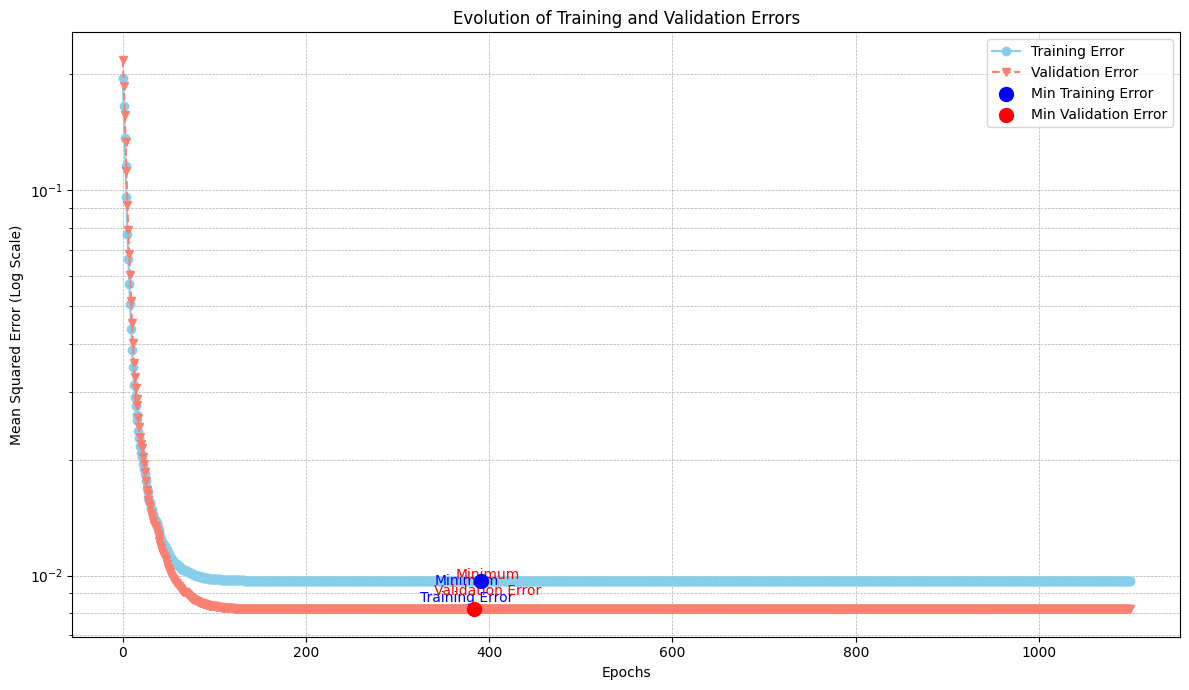

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 7))

# training and validation Errors
train_errors = loss_history[:, 0]
val_errors = loss_history[:, 1]

# plotting
plt.plot(train_errors, label='Training Error', marker='o', linestyle='-', color='skyblue')
plt.plot(val_errors, label='Validation Error', marker='v', linestyle='--', color='salmon')

# highlighting the minimum points
min_train_error_idx = np.argmin(train_errors)
min_val_error_idx = np.argmin(val_errors)
plt.scatter(min_train_error_idx, train_errors[min_train_error_idx], color='blue', s=100, label='Min Training Error', zorder=5)
plt.scatter(min_val_error_idx, val_errors[min_val_error_idx], color='red', s=100, label='Min Validation Error', zorder=5)

# annotations
plt.annotate(f'Minimum\nTraining Error', (min_train_error_idx, train_errors[min_train_error_idx]), textcoords="offset points", xytext=(-10,-15), ha='center', color='blue')
plt.annotate(f'Minimum\nValidation Error', (min_val_error_idx, val_errors[min_val_error_idx]), textcoords="offset points", xytext=(10,10), ha='center', color='red')

# labels and Title
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Log Scale)')
plt.yscale('log')
plt.title('Evolution of Training and Validation Errors')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Scatter plot

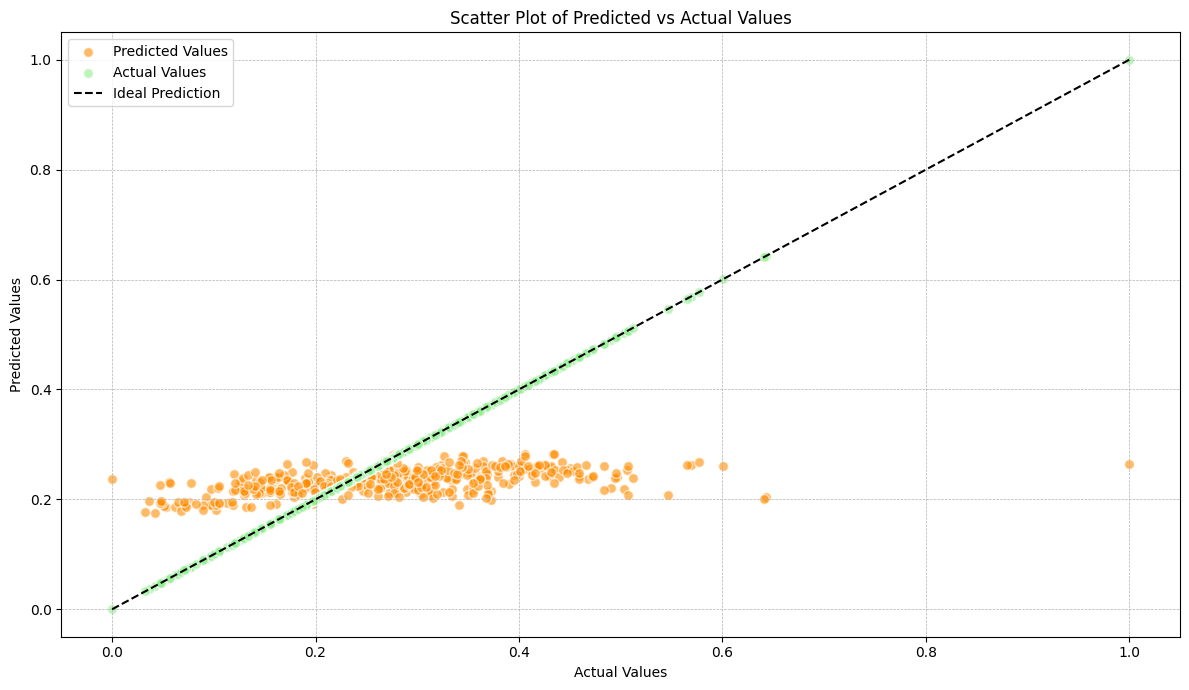

In [30]:

# Scatter plot with diagonal line and separate colors for predicted and actual values
predictions = nn.predict(X)
plt.figure(figsize=(12, 7))

# Predictions vs Actual Values
plt.scatter(y, predictions, color='darkorange', label='Predicted Values', alpha=0.6, edgecolors='w', s=50)
plt.scatter(y, y, color='lightgreen', label='Actual Values', alpha=0.6, edgecolors='w', s=50)

# Line of Identity (y=x line to show where predicted = actual)
line_start = min(y.min(), predictions.min())
line_end = max(y.max(), predictions.max())
plt.plot([line_start, line_end], [line_start, line_end], 'k--', label='Ideal Prediction')

# Labels and Title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
